# Proyecto Claudia version 3


# User definitions

You can modify these parameters as needed


In [ ]:
# -------------------------------
# Physical parameters of the binary system
m1Mo           = 36                # Mass 1 (units of solar masses)
m2Mo           = 29                # Mass 2 (units of solar masses)
DMpc           = 420               # Distance (in Mpc)
iota           = 1.05              # Angle iota [-pi,pi] (in rad) - 60°==1.05



In [ ]:
# -------------------------------
# Parameters imposed by the detector characteristics

# Chirp minimum frequency
flow           = 20                # (Hz)

# Default resampling frequency
fs             = 16384             # Sampling frequency (Hz)

In [ ]:
# -------------------------------
# Post-Neutonian order
PNorder        = 1                 # (0,  1.0,  1.5,  2.0,  2.5,  3.0,  3.5)


In [ ]:
# -------------------------------
# Define path
Ruta            = "/content/drive/My Drive/Colab Notebooks/ToolboxPostNewtonian/"


In [ ]:
# -------------------------------
# For debugging
doprint        = True              # (False: no  | True: yes)
doplot         = True              # (False: no  | True: yes)


In [ ]:
# -------------------------------
# OTROS PARAMETROS QUE SE REQUIEREN ENTENDER

# -------------------------------
# Termination phase
phi_0         = 0


# Import libraries

In [ ]:
# -------------------------------
# Import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#import scipy as sp
#import pandas as pd
#import seaborn as sns

# -------------------------------
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

# -------------------------------
# Insert the directory
import sys
sys.path.insert(0,Ruta)

# -------------------------------
# Import custom made functions
import ToolboxPostNewtonian as PN


Mounted at /content/drive


# Constants

In [ ]:
# Gravitational constant
G              = 6.67430e-11       # m^3 kg^−1 s^−2

# Velocity of light (m/s)
c              = 2.99792458e8      # m/s
c2             = np.power(c,2)     # c^2
c3             = np.power(c,3)     # c^3
c4             = np.power(c,4)     # c^4

# Cosmological constant
CC             = 2.9e-62           # m^-2


# 1. Calculations

Compute information as $m_1$ and $m_2$ in MKS units, reduced mas $\mu$, symmetric mass ratio $\eta$, duration of the signal $T_{chirp}$, etc.

In [ ]:
# -------------------------------
# Compute all the information
D, m1, m2, Mtotal, mu, nu, Mchirp, fisco, Ncyc, Tchirp, Nsamples, \
t, t_coal, phi_coal = PN.GWphysicalinformation(DMpc, m1Mo, m2Mo, flow, fs, PNorder, doprint)


Distance:                        1.30e+25 m
Mass 1:                          7.16e+31 kg
Mass 2:                          5.77e+31 kg
Total mass:                      1.29e+32 kg
Reduced mass:                    3.19e+31 kg
Symmetric mass ratio:            0.25
Chirp mass:                      5.59e+31 kg
Frequency isco:                  67.65 Hz
Number of cycles:                23.50
Duration of the GW signal:       1.19 s
Number of samples in the signal: 19453


# 2. Compute $\Theta(t)$


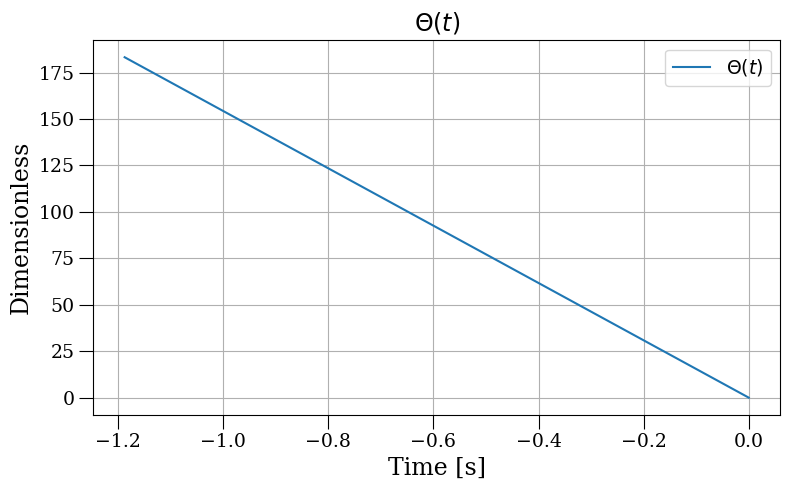

In [ ]:
# -------------------------------
# Compute and plot $\Theta(t)$
Thetat = PN.GWtheta(nu, Mtotal, t_coal, t, True)


# Compute $\int \Theta^{-11/8}I(\Theta)d\Theta$



\begin{eqnarray}
&& \int \Theta^{-11/8}I(\Theta)d\Theta = -\frac{8192\nu}{375}\Theta^{1/8}\left[ 35\nu\sin\left(\frac{2\Theta^{5/8}}{\nu}\right) \right.\nonumber\\
&& \left. + 20 \Theta^{5/8}\left(F_{\frac{1}{5}}\left(-\frac{2i\Theta^{5/8}}{\nu}\right) + F_{\frac{1}{5}}\left(\frac{2i\Theta^{5/8}}{\nu}\right)\right) \right.\nonumber\\
&& \left. + 7\nu\left(iF_{\frac{3}{5}}\left(\frac{2i\Theta^{5/8}}{\nu}\right) - iF_{\frac{3}{5}}\left(-\frac{2i\Theta^{5/8}}{\nu}\right)\right)\right]
\end{eqnarray}


where,

$F_{n}(x) := x^{n-1} \Gamma(1-n,x)$

and

$\Gamma(1-n,x) = \int_{x}^{\infty}t^{-n}e^{-t}dt = E_n(x) $

Therefore,

$F_{n}(x) := x^{n-1} E_n(x)$

Note that $\Gamma(1-n,x)$ is simply $E_n(x)$ which is implemented in the Python function `mpmath.expint(n,x)`

<font color='red'> CAUTION: Please be sure that `mpmath.expint(n,x)` is effectivelly equal to $\int_{x}^{\infty}t^{-n}e^{-t}dt$. I do not see that [here](https://mpmath.org/doc/current/functions/expintegrals.html#expint) </font>




**Decomposition for easy implementation:**

$INT = A ( T1 + T2 + T3 )$

$A = -\frac{8192\nu}{375}\Theta^{1/8}$

$T1 = 35\nu\sin\left(\frac{2\Theta^{5/8}}{\nu}\right)$

$T2 = + 20 \Theta^{5/8}\left(F_{\frac{1}{5}}\left(-\frac{2i\Theta^{5/8}}{\nu}\right) + F_{\frac{1}{5}}\left(\frac{2i\Theta^{5/8}}{\nu}\right)\right) = 20 \Theta^{5/8} \left(f15p + f15n\right)$

$T3 = + 7\nu\left(iF_{\frac{3}{5}}\left(\frac{2i\Theta^{5/8}}{\nu}\right) - iF_{\frac{3}{5}}\left(-\frac{2i\Theta^{5/8}}{\nu}\right)\right) = 7\nu\left( if35p-if35n \right)$

where, for instance, the function $ F_{\frac{1}{5}}\left(-\frac{2i\Theta^{5/8}}{\nu}\right) = f15n = Function(n,x) $ is a custom-made funtion with inputs

$n = 1/5$

and

$x = -\frac{2i\Theta^{5/8}}{\nu} $

In [ ]:
# -------------------------------
# Import mpmath library
import mpmath as mp

# -------------------------------
# Function to compute $F_{n}(x)$ when "n" is a number and "x" is an array
def calculate_Fnx_xisarray(n,xarray):
    # Initialize lists for the real and imaginary part of the solution
    FnxReal = []
    FnxImag = []

    # For each value in "xarray"
    for x_i in xarray:
        # Compute $F_{n}(x)$ for the current value x_i
        Fnx_i      = np.power(x_i, n-1) * mp.expint(n, x_i)

        # Save the real part in the list
        FnxReal.append( float(mp.nstr(Fnx_i.real, n=8)) )

        # Save the imag part in the list
        FnxImag.append( float(mp.nstr(Fnx_i.imag, n=8)) )

    # Convert lists to arrays
    FnxReal = np.array( FnxReal )
    FnxImag = np.array( FnxImag )

    # Construct Fnx as an array of complex numbers
    Fnx     = FnxReal + FnxImag

    # Return results
    return Fnx


In [ ]:
# -------------------------------
# Termino A
A        = -(8192/375)*nu*np.power(Thetat,1/8)

# -------------------------------
# Termino T1
T1       = 35*nu*np.sin( 2*np.power(Thetat,5/8)/nu )

# -------------------------------
# Termino T2
n        = 1/5

x        = 2*1j*np.power(Thetat,5/8)/nu
f15p     = calculate_Fnx_xisarray(n,+x)
f15n     = calculate_Fnx_xisarray(n,-x)

T2        = 20*np.power(Thetat,5/8) * ( f15n + f15p )

# -------------------------------
# Termino T3
n        = 3/5

x        = 2*1j*np.power(Thetat,5/8)/nu
f35p     = calculate_Fnx_xisarray(n,+x)
f35n     = calculate_Fnx_xisarray(n,-x)

T3       = 7*nu * ( 1j*f35p - 1j*f35n )

# -------------------------------
# Compute integral
INT      = A * ( T1 + T2 + T3 )


<font color='red'> **COMMENTS** </font>

- El resultado INT es complejo, i.e., la solucion a la integral es un arreglo (array) de numeros complejos

- Esto genera problemas pues entonces la phase $\phi(t)$ tambien sera un arreglo de numeros complejos

- La parte imaginaria de INT aparece debido al termino $T3$, y en particular a los numeros imaginarios alli contenidos, no se debe al resultado de la funcion $F_{n}(x)$





In [ ]:
print("INT:      ", INT      )
print("A value:  ", INT[0]   )
print("A value:  ", INT[467] )


INT:       [-27.31939429 -0.01903403j -27.89295903 -0.01907724j
 -28.46525529 -0.01911959j ...  -6.85363669 +4.69441706j
   1.80949272 +8.95302685j  13.79888725+17.93684229j]
A value:   (-27.319394293434407-0.01903403028145404j)
A value:   (29.470349056420346+0.019548282952402934j)


In [ ]:
print("T2:       ", T2      )
print("A value:  ", T2[0]   )
print("A value:  ", T2[467] )


T2:        [ 0.05583297  0.05556488  0.05529425 ... -4.63485624 -5.9637222
 -8.25182994]
A value:   0.05583296538714904
A value:   -0.05543475765858665


In [ ]:
print("T3:       ", T3     )
print("A value:  ", T3[1]  )
print("A value:  ", T3[78] )


T3:        [0.+1.83827224e-03j 0.+1.84245760e-03j 0.+1.84655939e-03j ...
 0.-1.35814062e+00j 0.-2.72486365e+00j 0.-5.95320543e+00j]
A value:   0.0018424576048473374j
A value:   0.0019041465344378698j


In [ ]:
print("f35p:     ", f35p     )
print("A value:  ", f35p[1]  )
print("A value:  ", f35p[78] )


f35p:      [ 7.08786880e-04  7.06412050e-04  7.04004750e-04 ... -1.26689842e+00
 -1.80543715e+00 -2.91058880e+00]
A value:   0.00070641205
A value:   0.00043602950999999996


In [ ]:
print("f35n:     ", f35n     )
print("A value:  ", f35n[1]  )
print("A value:  ", f35n[78] )


f35n:      [-3.5397998e-04 -3.5877451e-04 -3.6355319e-04 ... -4.8171176e-01
 -2.3010205e-01  5.3115900e-01]
A value:   -0.00035877451
A value:   -0.00066482149


# Compute $\phi(t)$

$\phi(t) = \phi_0-\frac{1}{\nu}\bigg[ \Theta^{5/8} $

$ + \left( \frac{3715}{8064}+\frac{55}{96}\nu \right)\Theta^{3/8} $

$ - \frac{800}{231}\frac{\Lambda G^2 m^2}{c^4}\Theta^{11/8} $

$ - \frac{5}{81}\frac{\Lambda G^2 m^2}{c^4}(1373+2204\nu)\Theta^{9/8} $

$ + \frac{495}{4096}(1-3\nu)\frac{\Lambda G^2 m^2}{c^4}\int \Theta^{-11/8}I(\Theta)d\Theta \bigg]$



In [ ]:
# -------------------------------
# Compute the phase (MAURICIO)

# Terms for 0 PN and the rest
P_k0           = 1
P_t0           = np.power(Thetat,5/8)

W_k0           = 1
W_t0           = np.power(Thetat,-3/8)

# Terms for 1 PN and the rest
P_k1           = (3715/8064) + (55/96)*nu
P_t1           = np.power(Thetat,3/8)

W_k1           = (743/2688) + (11/32)*nu
W_t1           = np.power(Thetat,-5/8)

# Terms for the new phase
Term3          = - (800/231)  * ( CC*G**2*(Mtotal**2)/c4 ) * np.power(Thetat, 11/8)
Term4          =    -(5/81)   * ( CC*G**2*(Mtotal**2)/c4 ) * np.power(Thetat,  9/8) * (1373 + 2204*nu)
Term5          = + (495/4096) * ( CC*G**2*(Mtotal**2)/c4 ) * (1-3*nu) * INT

# Sum terms for the orbital phase phi(t) and frequency w(t)
P_0pn         = (-1/nu)           * (P_k0*P_t0)
W_0pn         = (c3/(8*G*Mtotal)) * (W_k0*W_t0)

P_1pn         = (-1/nu)           * (P_k0*P_t0 + P_k1*P_t1)
W_1pn         = (c3/(8*G*Mtotal)) * (W_k0*W_t0 + W_k1*W_t1)

P_1pnCC       = (-1/nu)           * (P_k0*P_t0 + P_k1*P_t1 + Term3 + Term4 + Term5)
#W_1pnCC       = NO EQUATION YET

# Final calculation of the f(t)
F_0pn         = W_0pn   / (2*np.pi)
F_1pn         = W_1pn   / (2*np.pi)
#F_1pnCC       = W_1pnCC / (2*np.pi)


In [ ]:
# -------------------------------
# Solucion rapida para eliminar la parte imaginaria
P_1pnCC      = np.real(P_1pnCC)


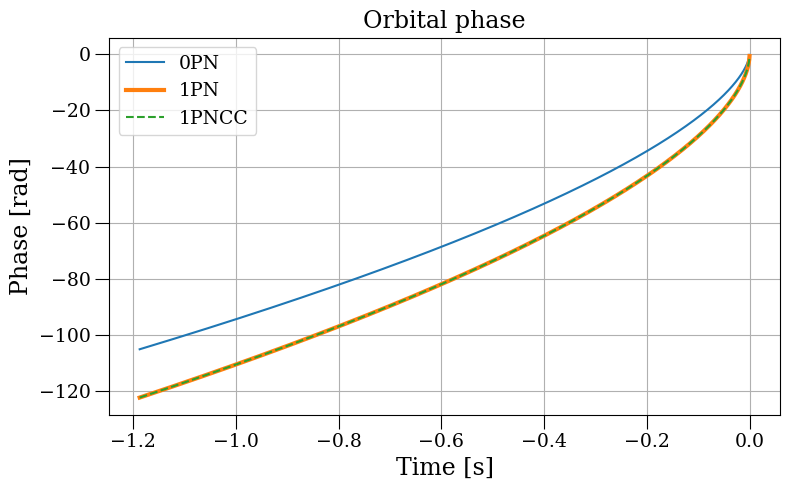

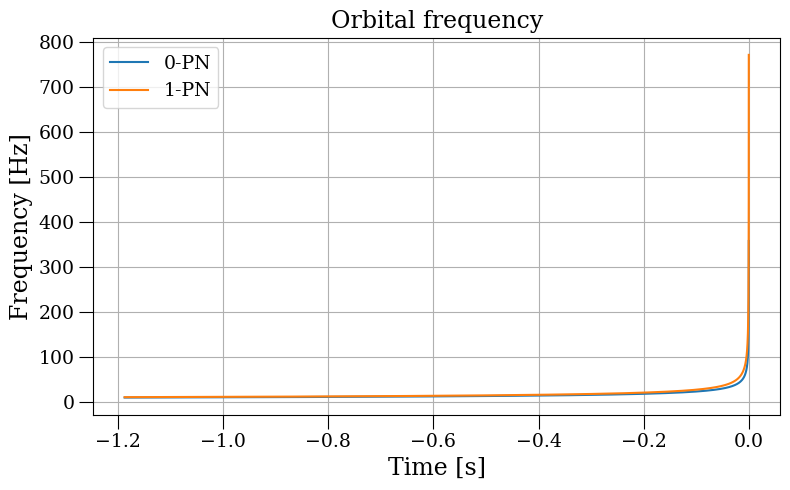

In [ ]:
# Plot
plt.figure()
plt.plot(t-t[-1], P_0pn        , label="0PN")
plt.plot(t-t[-1], P_1pn        , label="1PN"  , linewidth=3)
plt.plot(t-t[-1], P_1pnCC, '--', label="1PNCC")
plt.title("Orbital phase")
plt.xlabel('Time [s]')
plt.ylabel('Phase [rad]')
plt.grid()
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot(t-t[-1], F_0pn, label="0-PN")
plt.plot(t-t[-1], F_1pn, label="1-PN")
#plt.plot(t-t[-1], F_1pn_CC, label=str(1)+" PN_CC")
plt.title("Orbital frequency")
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# -------------------------------
# Comparar los valores de la fase en 1PN y 1PNCC
for phi1PN, phi1PNCC in zip(P_1pn,P_1pnCC):
    print("{0:.10f} {0:.10f}".format(phi1PN, phi1PNCC) )


Se han truncado las últimas 5000 líneas del flujo de salida.
-55.2932938449 -55.2932938449
-55.2868986824 -55.2868986824
-55.2805030014 -55.2805030014
-55.2741068017 -55.2741068017
-55.2677100832 -55.2677100832
-55.2613128457 -55.2613128457
-55.2549150892 -55.2549150892
-55.2485168133 -55.2485168133
-55.2421180181 -55.2421180181
-55.2357187033 -55.2357187033
-55.2293188688 -55.2293188688
-55.2229185144 -55.2229185144
-55.2165176400 -55.2165176400
-55.2101162455 -55.2101162455
-55.2037143307 -55.2037143307
-55.1973118955 -55.1973118955
-55.1909089396 -55.1909089396
-55.1845054630 -55.1845054630
-55.1781014656 -55.1781014656
-55.1716969471 -55.1716969471
-55.1652919073 -55.1652919073
-55.1588863463 -55.1588863463
-55.1524802638 -55.1524802638
-55.1460736596 -55.1460736596
-55.1396665337 -55.1396665337
-55.1332588858 -55.1332588858
-55.1268507158 -55.1268507158
-55.1204420236 -55.1204420236
-55.1140328091 -55.1140328091
-55.1076230720 -55.1076230720
-55.1012128122 -55.1012128122
-55.09480

In [ ]:
#from ast import Lambda

# -------------------------------
# Compute the phase (CLAUDIA)

# Terms for 0 PN and the rest
P_k0           = 1
P_t0           = np.power(Thetat,5/8)

W_k0           = 1
W_t0           = np.power(Thetat,-3/8)

# Terms for 1 PN and the rest
P_k1           = (3715/8064) + (55/96)*nu
P_t1           = np.power(Thetat,3/8)

W_k1           = (743/2688) + (11/32)*nu
W_t1           = np.power(Thetat,-5/8)

# Terms for cosmological constant 1 PN and the rest
ACC           = CC*G**2*c2/c4
P_t           = np.power(Thetat,3/4)
P_tt          = np.power(Thetat,5/8)/nu
P_tt1         = np.power(P_tt,3/5)
P_tt2         = np.power(P_tt,6/5)

#IncGamma      =

Theta_CC      = -P_t0/nu
Int_CC        = -(4096*nu**2)/(375*P_t)*(7*np.power(2,3/5)*nu*(-P_tt1)*1 \
              +7*np.power(2,3/5)*nu*P_tt1*1-20*np.power(2,1/5)*nu*(-P_tt2)*1 \
              -20*np.power(2,1/5)*nu*P_tt2*1) \
              + 70*P_t0*np.sin(-2*P_tt)


W_CC_1        = -(800/231)
W_tC_1        = np.power(Thetat,11/8)

W_CC_2        = -(5/81)*(1373 + 2204*nu)
W_tC_2        = np.power(Thetat,9/8)

W_CC_3        = (495/4096)*(1-3*nu)
W_tC_3        = np.power(Thetat,-11/8)

W_CC_T        = W_CC_1*ACC*W_tC_1 + W_CC_2*ACC*W_tC_2 + W_CC_3*ACC*W_tC_3*Int_CC

# Sum terms for the orbital phase phi(t) and frequency w(t)
P_0pn         = (-1/nu) *(P_k0*P_t0)
W_0pn         = (c3/(8*G*Mtotal)) * (W_k0*W_t0)

P_1pn         = (-1/nu) * (P_k0*P_t0 + P_k1*P_t1)
W_1pn         = (c3/(8*G*Mtotal)) *(W_k0*W_t0 + W_k1*W_t1)

# Final calculation of the f(t)
F_0pn         = W_0pn / (2*np.pi)
F_1pn         = W_1pn / (2*np.pi)
F_1pn_CC      = (W_1pn + W_CC_T) / (2*np.pi)


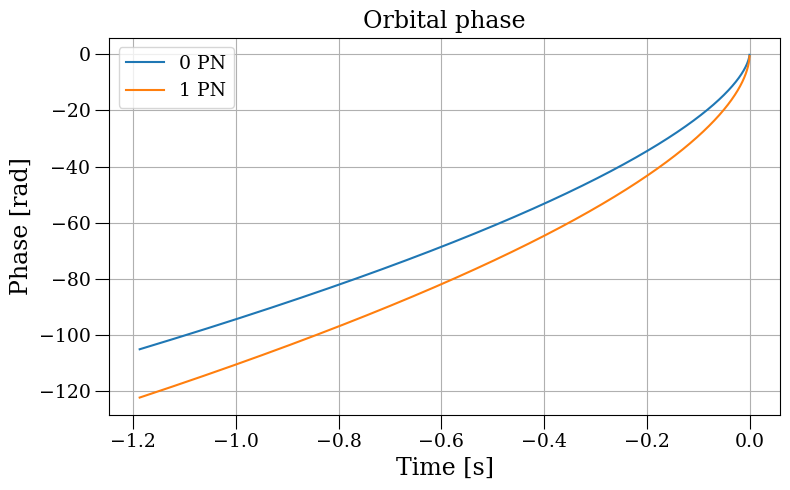

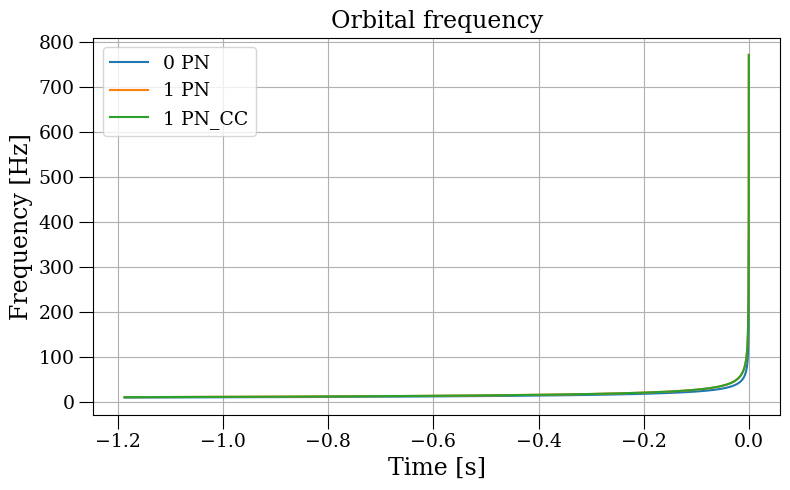

In [ ]:
# Plot
plt.figure()
plt.plot(t-t[-1], P_0pn, label=str(0)+" PN")
plt.plot(t-t[-1], P_1pn, label=str(1)+" PN")
plt.title("Orbital phase")
plt.xlabel('Time [s]')
plt.ylabel('Phase [rad]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


plt.figure()
plt.plot(t-t[-1], F_0pn, label=str(0)+" PN")
plt.plot(t-t[-1], F_1pn, label=str(1)+" PN")
plt.plot(t-t[-1], F_1pn_CC, label=str(1)+" PN_CC")
plt.title("Orbital frequency")
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


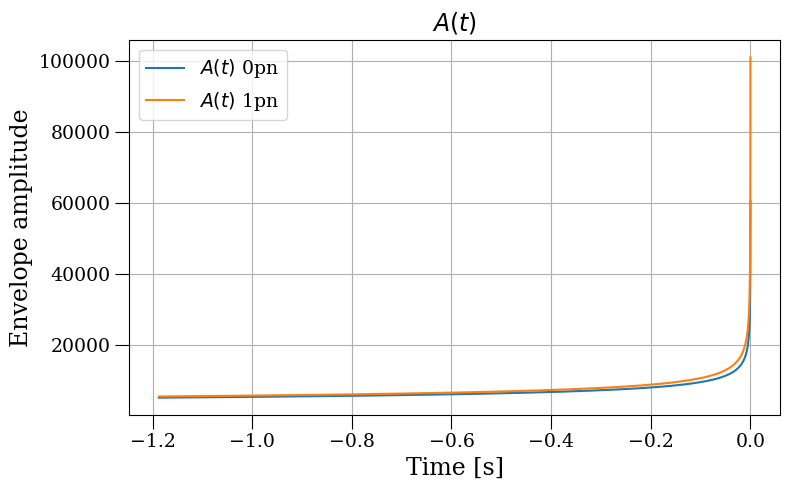

In [ ]:
# Compute GW phase and frequency
phit              = 2*P_0pn - phi_0
ft_0pn            = 2*F_0pn
ft_1pn            = 2*F_1pn

# Compute A(t)
#At_0pn            = 4 * np.power(G*Mchirp/c2,5/3) * np.power(np.pi*ft_0pn/c,2/3)
#At_1pn            = 4 * np.power(G*Mchirp/c2,5/3) * np.power(np.pi*ft_1pn/c,2/3)

At_0pn_CC          = 2 * G* mu/c4 * np.power(2 * G * Mtotal * np.pi*ft_0pn, 2/3)
At_1pn_CC          = 2 * G* mu/c4 * np.power(2 * G * Mtotal * np.pi*ft_1pn, 2/3)

# Plot
plt.figure()
plt.plot(t-t[-1], At_0pn_CC, label="$A(t)$ 0pn")
plt.plot(t-t[-1], At_1pn_CC, label="$A(t)$ 1pn")
plt.title("$A(t)$")
plt.xlabel('Time [s]')
plt.ylabel('Envelope amplitude')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

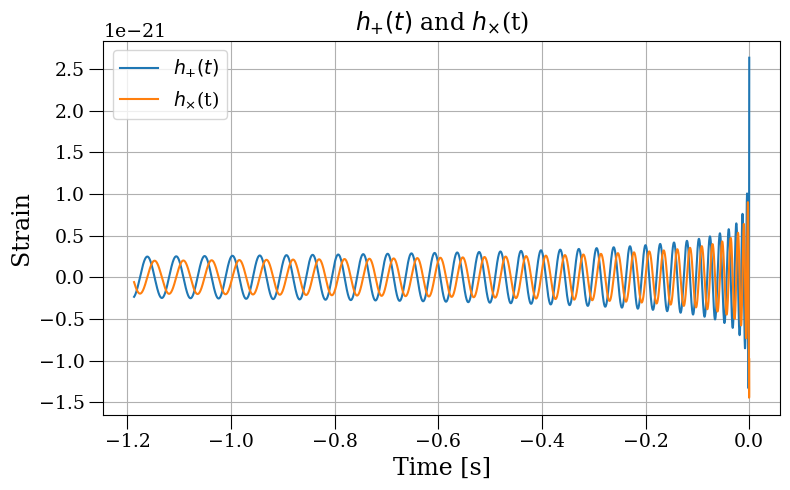

In [ ]:
# Compute GW: hp and hc polarizations
hp            = (1/D) * At_0pn_CC * (1+np.cos(iota)**2)/2  * np.cos(phit)
hc            = (1/D) * At_0pn_CC * np.cos(iota)           * np.sin(phit)

# Plot
plt.figure()
plt.plot(t-t[-1], hp, label=r"$h_{+}(t)$")
plt.plot(t-t[-1], hc, label=r"$h_{\times}$(t)")
plt.title(r"$h_{+}(t)$ and $h_{\times}$(t)")
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.grid()
#plt.xlim(-0.1,0.001)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Compute GW: hp and hc polarizations with Cosmological Constant
hp            = (1/D) * At_0pn_CC * (1+np.cos(iota)**2)/2  * np.cos(phit)
hc            = (1/D) * At_0pn_CC * np.cos(iota)           * np.sin(phit)

omega         = 1
phi           = 1

hp_CC         = (CC*c2/omega**2)*(-np.sin(iota)**2/12+ \
                5*(1+np.cos(iota)**2)*np.cos(2*phi)/36) - \
                (m1-m2)*np.power(G*Mtotal * omega,1/3) * np.sin(iota)/(8*c)* \
                ((5+np.cos(iota)**2)*np.cos(phi)-9*(1+np.cos(iota)**2)*np.cos(3*phi)-
                (CC*c2)/(3*omega**2)*((5+np.cos(iota)**2)*np.cos(phi) - \
                9*(1+np.cos(iota)**2)*np.cos(3*phi))+
                np.power(G*Mtotal * omega,2/3)/c2*((3-nu)*np.sin(iota)**2/2 +
                np.cos(2*phi)*((19+9*np.cos(iota)**2-2*np.power(np.cos(iota),4))- \
                nu*(19-11*np.cos(iota)**2-6*np.power(np.cos(iota),4))/6- \
                4*np.sin(iota)**2*(1+np.cos(iota)**2)*(1-3*nu)*np.cos(4*phi)/3) +
                CC*np.power(G*Mtotal * omega,2/3)/(omega**2)* \
                (13/24-9*np.cos(iota)**2/16+np.power(np.cos(iota),4)/48+275*nu*np.sin(iota)**2/72)+ \
                np.cos(2*phi)*(-371/432-35*np.cos(iota)**2/144+35*np.power(np.cos(iota),4)/108+ \
                + nu*(331/144+65*np.cos(iota)**2/144+35*np.power(np.cos(iota),4)/36)) + \
                np.cos(4*phi)*(5/18+11*np.cos(iota)**2/54-13*np.power(np.cos(iota),4)/27) + \
                nu*(-5/6-69*np.cos(iota)**2/72+13*np.power(np.cos(iota),4)/9)))
hc_CC         = (CC*c2)/(9*np.power(omega,2))*np.sin(2*phi)*np.cos(iota)+ \
                (3*(-m1+m2)*np.sin(2*iota)*np.power(G*Mtotal * omega,1/3))/(8*c)* \
                ((1+(2*CC*c2)/(9*omega**2))*np.sin(phi) - \
                (3-(20*CC*c2)/(9*(omega)**2))*np.sin(3*phi) + \
                np.cos(iota)*np.power(G*Mtotal * omega,2/3)/c2* \
                (((17/3-4*np.cos(iota)**2/3)+nu*(-13/3+4*np.cos(iota)**2))*np.sin(2*phi) \
                -8*(1-3*nu)*np.sin(iota)**2*np.sin(4*phi)/3 +
                (CC*c2)/(omega)**2*((-92/27+np.cos(iota)**2/3)+nu*(79/18-13*np.cos(iota)**2/6))
                *np.sin(2*phi)+ (CC*c2)/(omega)**2*((359/216-359*nu/72)* \
                 np.sin(iota)**2)*np.sin(4*phi)))


# Plot
plt.figure()
plt.plot(t-t[-1], hp_CC, label=r"$h_{+}(t)$")
#plt.plot(t-t[-1], hc, label=r"$h_{\times}$(t)")
plt.title(r"$h_{+}(t)$ and $h_{\times}$(t)")
plt.xlabel('Time [s]')
plt.ylabel('Strain')
plt.grid()
#plt.xlim(-0.1,0.001)
plt.legend()
plt.tight_layout()
plt.show()

ValueError: ignored

# Compute $h_{+}(t)$

$h_{+} = \frac{2G\mu}{c^4 R}(Gm\omega)^{2/3}\bigg \lbrace -(1+\mathrm{cos}^2\iota)\mathrm{cos}2\phi+\frac{\Lambda c^2}{\omega^2}\left(  -\frac{1}{12}\mathrm{sin}^2 \iota+\frac{5}{36}(1+\mathrm{cos}^2\iota)\mathrm{cos}2\phi \right) \\
        +\frac{\Delta m}{c}\left( -\frac{1}{8}(Gm\omega)^{1/3}\mathrm{sin}\iota \right)\bigg[ (5+\mathrm{cos}^2 \iota)\mathrm{cos}\phi-9(1+\mathrm{cos}^2\iota)\mathrm{cos}3\phi-\frac{\Lambda c^2}{3\omega^2}[(5+\mathrm{cos}^2\iota)\mathrm{cos}\phi-9(1+\mathrm{cos}^2\iota)\mathrm{cos}3\phi] \bigg]  \\
        +\frac{1}{c^2}(Gm\omega)^{2/3}\bigg[ \frac{1}{2}(3-\nu)\mathrm{sin}^2\iota+\frac{1}{6}\lbrace [19+9\mathrm{cos}^2\iota-2\mathrm{cos}^4\iota]-\nu[19-11\mathrm{cos}^2\iota-6\mathrm{cos}^4\iota] \rbrace \mathrm{cos}2\phi   \\
        -\frac{4}{3}\mathrm{sin}^2\iota(1+\mathrm{cos}^2\iota)(1-3\nu)\mathrm{cos}4\phi \bigg]  \\
        +\frac{\Lambda}{\omega^2}(Gm\omega)^{2/3} \left\lbrace \frac{13}{24}-\frac{9}{16}\mathrm{cos}^2\iota+\frac{1}{48}\mathrm{cos}^4\iota+\frac{275}{72}\nu \mathrm{sin}^2\iota+\mathrm{cos}2\phi \bigg[ -\frac{371}{432}-\frac{35}{144}\mathrm{cos}^2\iota -\frac{35}{108}\mathrm{cos}^4\iota \right.  \\
        + \nu\bigg( \frac{331}{144}+\frac{65}{144}\mathrm{cos}^2\iota+\frac{35}{36}\mathrm{cos}^4\iota \bigg) \bigg]  \\
        + \left. \mathrm{cos}4\phi\bigg[ \frac{5}{18}+\frac{11}{54}\mathrm{cos}^2\iota-\frac{13}{27}\mathrm{cos}^4\iota+\nu \bigg( -\frac{5}{6}-\frac{69}{72}\mathrm{cos}^2\iota+\frac{13}{9}\mathrm{cos}^4\iota \bigg) \bigg] \right\rbrace   \bigg\rbrace$


In [ ]:
# -------------------------------
# Compute hp
#hp            = (1/D) * At * (1+np.cos(iota)**2)/2  * np.cos(phit)


# Compute $h_{\times}(t)$

$h_{\times}=\frac{2G\mu}{c^4 R} (Gm\omega)^{2/3} \bigg\lbrace -2\mathrm{cos}\iota \mathrm{sin}2\phi +\frac{\Lambda c^2}{9\omega^2}\mathrm{cos}\iota \mathrm{sin}2\phi \\
        +\frac{\Delta m}{c}\bigg( -\frac{3}{8}(Gm\omega)^{1/3}\mathrm{sin}2\iota \bigg)\bigg[ \bigg( 1+\frac{2}{9}\frac{\Lambda c^2}{\omega^2} \bigg)\mathrm{sin}\phi -\bigg( 3-\frac{20}{9}\frac{\Lambda c^2}{\omega^2}
 \bigg)\mathrm{sin}3\phi \bigg] \\
 +\frac{1}{c^2}(Gm\omega)^{2/3}\mathrm{cos}\iota \bigg[ \left \lbrace  \bigg( \frac{17}{3}-\frac{4}{3}\mathrm{cos}^2\iota \bigg)+\nu \bigg( -\frac{13}{3}+4\mathrm{cos}^2\iota \bigg)  \right \rbrace \mathrm{sin}2\phi -\frac{8}{3}(1-3\nu)\mathrm{sin}^2\iota \mathrm{sin}4\phi \\
 +\frac{\Lambda c^2}{\omega^2} \left \lbrace  \bigg( -\frac{92}{27}+\frac{1}{3}\mathrm{cos}^2\iota \bigg)+\nu \bigg( \frac{79}{18}-\frac{13}{6}\mathrm{cos}^2\iota
 \bigg)  \right \rbrace \mathrm{sin}2\phi +\frac{\Lambda c^2}{\omega^2} \left \lbrace  \bigg( \frac{359}{216}-\frac{359}{72}\nu \bigg)\mathrm{sin}^2\iota  \right \rbrace \mathrm{sin}4\phi \bigg] \bigg \rbrace $

In [ ]:
# -------------------------------
# Compute hc
#hc            = (1/D) * At * np.cos(iota)           * np.sin(phit)